# Clustering 

## 1. DBSCAN
Using DBSCAN iterate (for-loop) through different values of `min_samples` (1 to 10) and `epsilon` (.05 to .5, in steps of .01)  to find clusters in the road-data used in the Lesson and calculate the Silohouette Coeff for `min_samples` and `epsilon`. Plot **_one_** line plot with the multiple lines generated from the min_samples and epsilon values. Use a 2D array to store the SilCoeff values, one dimension represents `min_samples`, the other represents epsilon.

Expecting a plot of `epsilon` vs `sil_score`.

In [5]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 12)
plt.rcParams['font.size'] = 14
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [3]:
X = pd.read_csv('../data/3D_spatial_network.txt.gz', header=None, names=['osm', 'lat','lon','alt'])
# X = X.drop(['osm'], axis=1).sample(10000)
X = X.drop(['osm'], axis=1).sample(10000)
X.head()

XX = X.copy()
XX['alt'] = (X.alt - X.alt.mean())/X.alt.std()
XX['lat'] = (X.lat - X.lat.mean())/X.lat.std()
XX['lon'] = (X.lon - X.lon.mean())/X.lon.std()

In [4]:
XX

,lat,lon,alt
266814,-2.185692,-0.525044,-0.225997
329502,1.150053,1.283287,0.453334
133464,0.193176,1.446246,-0.795926
100698,-1.867672,-0.500631,0.483551
197995,0.456679,-0.050830,-1.100584
...,...,...,...
304756,0.218663,0.779424,-0.207463
73667,0.415230,-0.172933,-0.244860
404866,-1.692018,-0.733243,1.478975
325510,0.772859,0.438048,1.559796


In [5]:
min_samples = np.arange(1,11,1)
epsilons = np.arange(.05,0.51,.01)

In [6]:
scores = []
for epsilon in epsilons:
    db = DBSCAN(eps = epsilon, min_samples=1)
    labels = db.fit_predict(XX[['lon', 'lat', 'alt']])
    # calculate silouette score here
    score = silhouette_score(XX[['lon', 'lat', 'alt']], labels)
    
    scores.append(score)

In [10]:
all_scores = []
for min_sample in min_samples:
    scores = []
    for epsilon in epsilons:
        db = DBSCAN(eps = epsilon, min_samples=min_sample)
        labels = db.fit_predict(XX[['lon', 'lat', 'alt']])
        # calculate silouette score here
        score = silhouette_score(XX[['lon', 'lat', 'alt']], labels)
        
        scores.append(score)
        
    all_scores.append(scores)

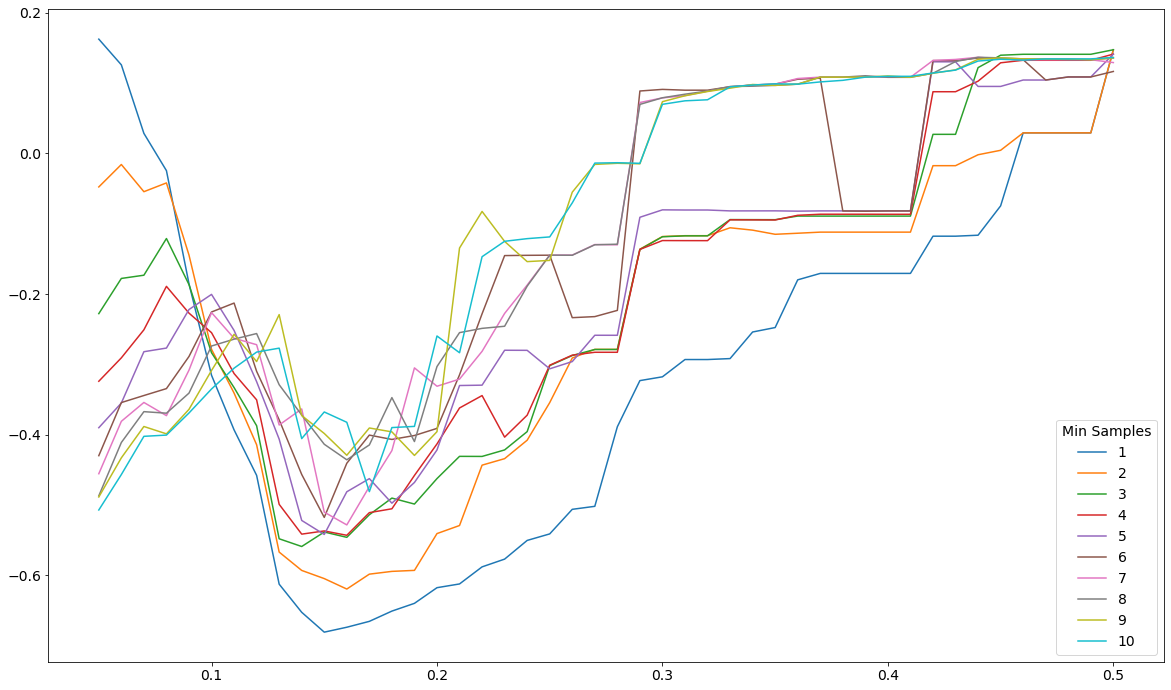

In [32]:
plt.figure()
for i in range(len(min_samples)):
    plt.plot(epsilons, all_scores[i], label = f"{i + 1}")
plt.legend(title = "Min Samples",loc = "lower right")

## 2. Clustering your own data
Using your own data, find relevant clusters/groups within your data (repeat the above). If your data is labeled with a class that you are attempting to predict, be sure to not use it in training and clustering. 

You may use the labels to compare with predictions to show how well the clustering performed using one of the clustering metrics (http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation). 

If you don't have labels, use the silhouette coefficient to show performance. Find the optimal fit for your data but you don't need to be as exhaustive as above.

Additionally, show the clusters in 2D or 3D plots. 

As a bonus, try using PCA first to condense your data from N columns to less than N.

Two items are expected: 
- Metric Evaluation Plot (like in 1.)
- Plots of the clustered data

In [2]:
beer_df = pd.read_csv('beer_reviews.csv')

In [21]:
beer = beer_df.copy()
beer = beer.dropna()
beer = beer.drop(
    ['brewery_id',
     'brewery_name',
     'review_time',
     'review_profilename',
     'beer_beerid',
     'beer_name'], axis = 1)
# beer = beer.reset_index(drop = True)
import random
beer_styles = list(beer.beer_style.value_counts().nlargest(10).index)
# random_beers = random.choices(beer_styles, k = 5)
beer = beer[beer.beer_style.isin(beer_styles)]
beer = beer.groupby('beer_style').apply(lambda x: x.sample(10000))
# beer = beer.sample(100000)
beer = beer.reset_index(drop = True)


In [22]:
def jitter(value, j):
    # return value + np.random.normal(j,0.15,value.shape)
    return value
features = ['review_overall',
 'review_aroma',
 'review_appearance',
 'review_palate',
 'review_taste',
 'beer_abv']

X = beer[features].values

X = StandardScaler().fit_transform(X)

pca = PCA(n_components = 2)

prin_comp = pca.fit_transform(X)

principal_df = pd.DataFrame(data = prin_comp,
                            columns = ['prin_comp1', 'prin_comp2'])

finaldf = pd.concat([principal_df, beer[['beer_style']]], axis = 1)


In [23]:
pca.explained_variance_ratio_

array([0.5812427 , 0.15885856])

<AxesSubplot:xlabel='prin_comp1', ylabel='prin_comp2'>

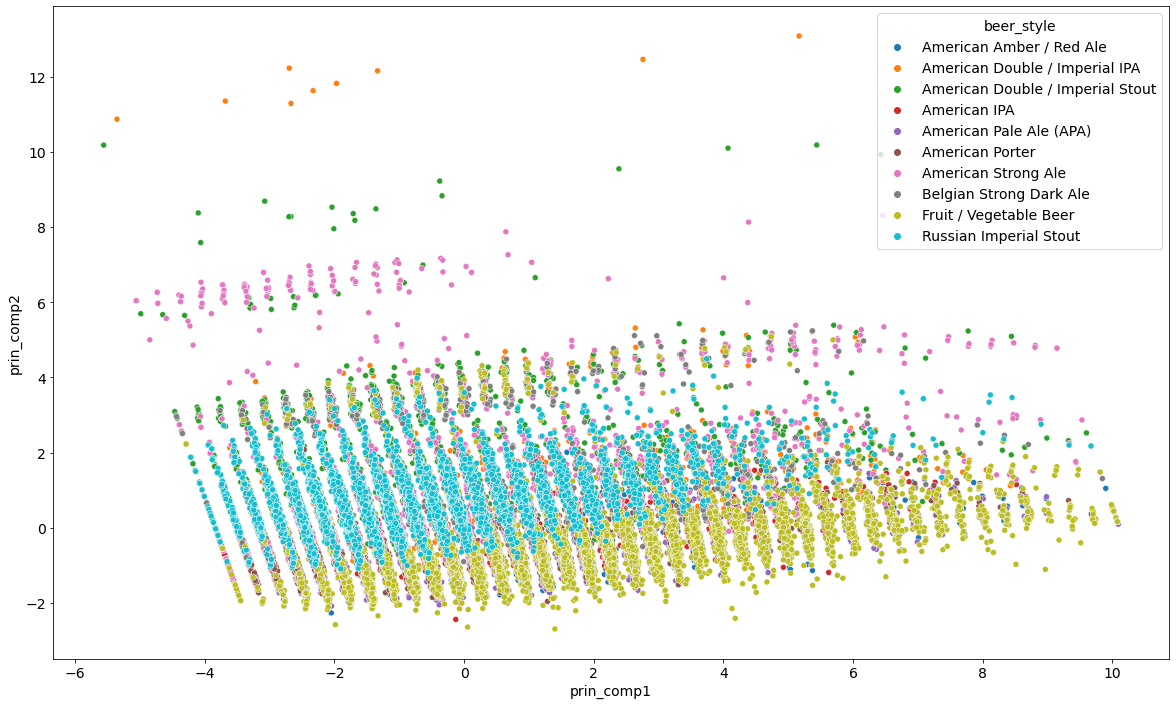

In [24]:

sns.scatterplot(data = finaldf,
                x = 'prin_comp1',
                y = 'prin_comp2', hue = 'beer_style')